<a href="https://colab.research.google.com/github/rkarmaka/SAM-using-Python-for-Microscopy-Data/blob/main/%5BCOURSE_TEMPLATE%5D_Segment_Anything_with_Python_for_Microscopy_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anything with Python for Microscopy Images

**Objective:** In this course, we'll explore the Segment Anything (SAM) model, a cutting-edge segmentation model based on Vision Transformers (ViT), introduced by Meta in April 2023. SAM was trained using 1 billion masks from 11 million diverse images. The model focuses primarly on natural images known for their pronounced edge details but actually stands out for its ability to perform zero-shot segmentation across a wide range of images including biological and medical image data. As of February 2024, SAM has gained significant recognition, cited in over 2,000 publications, and inspired various adaptations for specific fields.

Designed with biologists, microscopists, and bio-image analysts in mind, this course focuses on leveraging SAM for biological imagery. We will guide you through using SAM within Python, employing examples from biology to illustrate its applications. The present materials support the workshop titled 'Segment Anything with Python for Microscopy Images' organized by Harvard Medical School's Image Analysis Collaboratory in 2024.

To ensure accessibility and convenience, we have based this course on Google Colab, making it adaptable for use on various platforms with minor adjustments.

By the course's conclusion, we aim for you to gain a thorough understanding of SAM's mechanics, how to apply it to your projects, and its potential and limitations within your field.

# Chapter 1: Introduction to SAM


## **Introduction:**

Segment Anything Model (SAM) is a foundation model [1] developed by Meta AI and introduced in the paper Segment Anything [2]. In this paper, authors have introduced a vision transformer-based foundation model for zero-shot segmentation tasks. One of the main powerful features of the model is that it is promptable using boxes, points, masks, or texts. SAM was trained with 1 billion masks from 11 million images. Significant testing showed that SAM performs better than a lot of fully supervised models and fine tuning SAM with specific tasks can lead to even more accurate results. Since the publication in April 2023, multiple different papers have been published in different fields such as medical imaging [3], and biological imaging [4, 5] that use SAM as a base model to segment their specific images.


## **Model Architecture:**

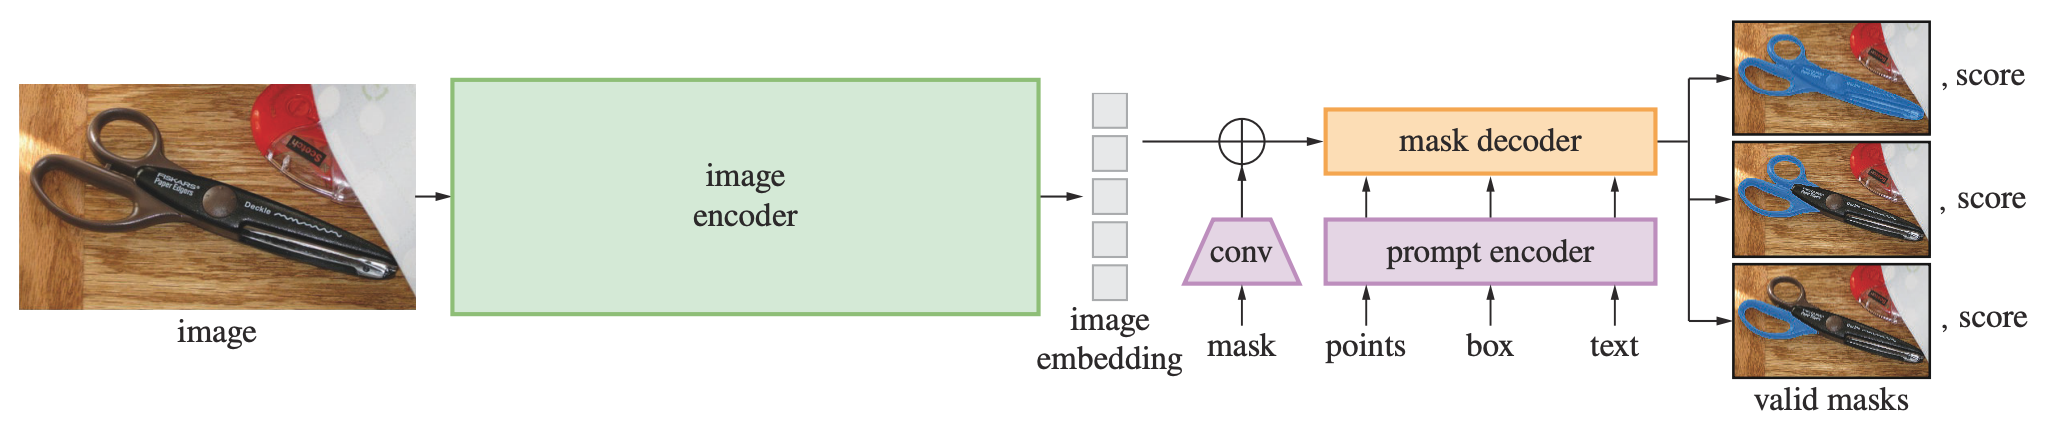

_(Source: Segment Anything [2])_

Above is the model architecture of SAM. It has three main building blocks: **image encoder**, **prompt encoder**, and **mask decoder**.

**Image encoder:** This block uses Vision Transformer (ViT) [6], pre-trained with Masked Autoencoder (MAE) [7] to create the image embedding. While this is the most time and resource consuming operation, it is run only once per image.

**Prompt encoder:** This block uses two sets of prompts: sparse prompts in the form of points, boxes and text, and dense prompts in the form of masks. Points and boxes are encoded using positional encodings [8], combined with unique learned embeddings for each type of sparse prompt. Free-form text is processed using a standard text encoder from CLIP [9]. For dense prompts, convolutional methods are used to embed them, and these embeddings are then integrated with the image embedding through element-wise summation.

**Mask decoder:** The mask decoder effectively transforms the image embedding, prompt embeddings, and an output token into a mask through a modified Transformer decoder block [10], followed by a dynamic mask prediction mechanism.

## **Model Checkpoints:**

In the beginning, SAM was trained with public, annotated datasets. As more annotations were created using SAM, new annotations were used to retrain SAM. Three model versions with different backbone sizes were made available which are ViT-B, ViT-L, and ViT-H where ViT-B is the base model and ViT-H is the biggest model. Model size significantly increased from ViT-B to ViT-H, so did the model's performance. However, ablation study showed that the performance increase between ViT-L and ViT-H is minimal as showed in the figure below. Hence, based on a given task, using the model ViT-L might just be sufficient.

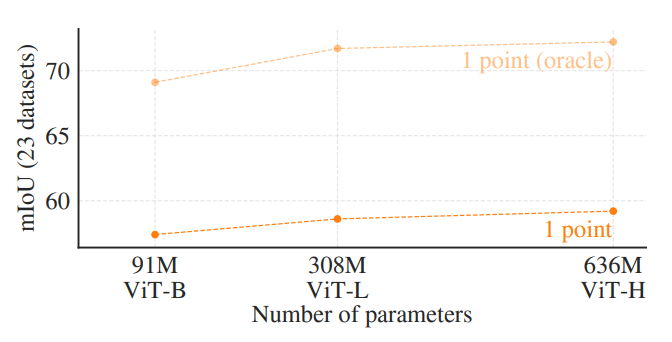

_(Source: Segment Anything [2])_
\
\
Model checkpoints can be downloaded from [here](https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#model-checkpoints).

# Chapter 2: Setting up SAM in Google Colab


Before we get started, it is important to setup your Colab notebook. Hence, we will run some steps to select GPU, and install SAM and related packages. As Colab comes pre-installed with PyTorch, we do not need to install Torch. However, if you are running SAM on your local computer or on a high performance computing (HPC) cluster, we may need to run a few extra steps to setup your environment for SAM.

## Chapter 2.1: Setup and installations

### Step 1: Change Runtime type



Go to _Runtime_ > _Change runtime type_ > _Select_ **T4 GPU** and hit _Save_.



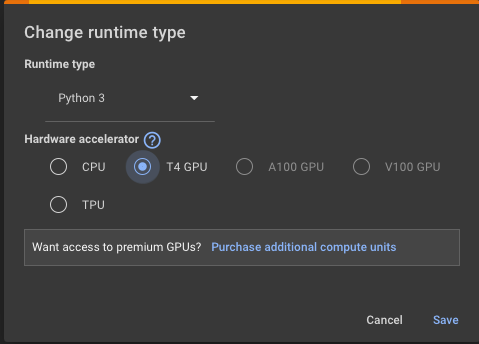

### Step 2: Mount Google Drive


For effective data management and model storage, integrating Google Drive is highly recommended. This approach offers a stable and permanent storage solution, unlike the temporary file storage in your workspace. Temporary storage is erased each time the runtime resets, leading to data loss. By establishing a directory system in Google Drive and mounting it, you can seamlessly access and manipulate data directly via Google Drive. Here’s how you can mount Google Drive:


**Using the Graphical User Interface (GUI):**
1. Locate the left-side panel in your workspace.
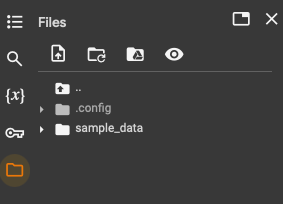
2. Click on the Google Drive icon Screenshot 2024-01-12 at 1.51.47 PM.png to initiate the mounting process.
3. A permission request will pop-up. Click on _Connect to Google Drive_ to proceed.
Note: You might be prompted to log into your Google account. If you have multiple Gmail accounts, ensure you select the one associated with your Google Colab account.


After you click on it, it would ask you for your permission. Please allow by clicking on _Connect to Google Drive_. It may ask you to sign in to your google account. If you are logged into multiple Gmail accounts, please make sure you select the account that you used to login to Google colab.



**Using code:**

Alternatively, you can mount Google Drive by executing the following two lines of code in your workspace. The authorization process remains the same as the GUI method.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

### Step 3: Install necessary packages


In this part of the course, we will install all the necessary packages for our project. First, we will install SAM, which is essential for the operations we will be performing. Along with SAM, we need [OpenCV](https://opencv.org/), a powerful library used for loading and manipulating images. For visual display purposes, we will also install [Matplotlib](https://matplotlib.org/), which is great for creating visualizations in Python. Lastly, we will add [Tifffile](https://pypi.org/project/tifffile/) to our setup, as it is specifically designed for reading .tif files. By installing these packages, you'll have all the required tools for effective image handling and visualization in our upcoming tasks.

As we are using Google Colab, we do not need to install [PyTorch](https://pytorch.org/) libraries, however, if you are running it locally, you may need to install necessary packages depending on the hardware you have available. You can check more information on how to install PyTorch [here](https://pytorch.org/get-started/locally/).

In [ ]:
# Install SAM
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

### Step 4: Create directory structure and load images


In this part of the course, we'll organize a directory structure in our Google Drive and download images from our GitHub repository. This step is optional; you're welcome to use a different directory structure and your own images if you prefer. However, for the purposes of this tutorial, we will proceed with the assumption that the images are located in the directory **_/content/drive/MyDrive/SAMWorkshop/images_**. If you choose a different structure or images, you may need to adjust some of the instructions accordingly.

In [ ]:
# Create directory structure
!mkdir '/content/drive/MyDrive/SAMWorkshop'
!mkdir '/content/drive/MyDrive/SAMWorkshop/images'
!mkdir '/content/drive/MyDrive/SAMWorkshop/ModelCheckpoints'
!mkdir '/content/drive/MyDrive/SAMWorkshop/ModelCheckpoints/SAM'

# Download images
!wget -P '/content/drive/MyDrive/SAMWorkshop/images' https://raw.githubusercontent.com/rkarmaka/SAM-using-Python-for-Microscopy-Image/main/images/1.jpg
!wget -P '/content/drive/MyDrive/SAMWorkshop/images' https://raw.githubusercontent.com/rkarmaka/SAM-using-Python-for-Microscopy-Image/main/images/ex1.jpg
!wget -P '/content/drive/MyDrive/SAMWorkshop/images' https://raw.githubusercontent.com/rkarmaka/SAM-using-Python-for-Microscopy-Image/main/images/2.png
!wget -P '/content/drive/MyDrive/SAMWorkshop/images' https://raw.githubusercontent.com/rkarmaka/SAM-using-Python-for-Microscopy-Image/main/images/3.png
!wget -P '/content/drive/MyDrive/SAMWorkshop/images' https://raw.githubusercontent.com/rkarmaka/SAM-using-Python-for-Microscopy-Image/main/images/4.png
!wget -P '/content/drive/MyDrive/SAMWorkshop/images' https://raw.githubusercontent.com/rkarmaka/SAM-using-Python-for-Microscopy-Image/main/images/5.png


## Chapter 2.2: Download model checkpoints and import necessary libraries

### Step 1: Download model checkpoint

Before we begin our practical work, it's essential to set up our environment. This involves downloading and loading a [model checkpoint](https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#model-checkpoints). In this example, we'll start with the default mode, 'vit_h', as our model of choice. However, feel free to explore other available model checkpoint. If you have developed your own model checkpoint, you're encouraged to use it in this exercise to see how it performs.

In [ ]:
# Download model checkpoint

### Step 2: Import libraries

In [ ]:
# Import libraries

# Chapter 3: Segment Everything with SAM

## Chapter 3.1: Segment all the objects in an image

In [ ]:
# Load an image

In [ ]:
# Write a functtion to display an image

In this module, we will use SAM in its default settings to see how it identifies each object present in the image and segments them. We will also investigate the output to see what information we can extract from it.

In [ ]:
# Import SAM

In [ ]:
# Load SAM model

In [ ]:
# Generate mask

In [ ]:
# What data structure is masks?

In [ ]:
# What is the length of masks?

In [ ]:
# What data structure is individual items inside masks?

In [ ]:
# What are the keys of each dictionar?

### Exercise 3.1: Load an image and run SAM on it

**Step 1:** Load the image ```ex1.jpg``` from the image directory and name the image variable ```image_2```

**Step 2:** Display the image you just loaded

**Step 3:** Generate masks for the new image. Name the variable ```masks_2```

**Step 4:** Check the datastructure type of ```masks_2```, length of ```masks_2```, type of data structure inside ```masks_2```, and they keys inside each items of ```masks_2```

**Sttep 5:** Report how many nuclei the model detected.

## Chapter 3.2: Display bounding boxes around each object detected by SAM

`segmentation`: Binary segmentation mask. \
`area`: This is the total number of pixels within the segmentation mask. It gives us a quantifiable size of the area covered by the mask. \
`bbox`: The bounding box is a rectangular box that frames the boundaries of the mask. It is defined in XYWH format, where 'X' and 'Y' represent the coordinates of the box's top-left corner, and 'W' and 'H' specify the width and height of the box, respectively. \
`predicted_iou`: This is the model's prediction of the mask's accuracy. It measures the overlap between the predicted mask and the actual area it's supposed to cover. A higher IOU indicates a more accurate mask. \
`point_coords`: These are the coordinates of the specific point that was used to generate the mask. It's the starting point from which the mask was developed. \
`stability_score`: This is an additional metric to assess the quality of the mask. It evaluates how consistent and reliable the mask is across various conditions or inputs. \
`crop_box`: This is the section of the original image that was used to generate the mask. Like the bounding box, it's defined in XYWH format and specifies the area of interest from which the mask was created. \

Now let us use `bbox` to draw bounding box around detected objects.

In [ ]:
# Display segmentation using bounding box

In [ ]:
## Draw bounding box around one nucleus

# Create a figure and axes object

# Add the image to the axes object

Similarly, now let us draw bounding boxes for more than one objects:

In [ ]:
## Draw bounding box around multiple nuclei

# Create a figure and axes object

# Add the image to the axes object

In [ ]:
# Write a function to display bounding boxes around all the objects detected

In [ ]:
# Display bounding boxes around all the objects detected

### Exercise 3.2: Display bounding boxes around all detected nuclei

**Step 1:** Use the function we just wrote to display bounding boxes around all the nuclei detected by you previously on image_2

**Step 2:** Report and discuss what you observed


## Chapter 3.3: Improve the results using input parameters

**Q. What input parameters do the automatic mask generator accept?**

**SamAutomaticMaskGenerator()** method has the following input arguments: \
`model`: The SAM model \
`points_per_side`: Number of points sampled along each side of the image, resulting in a total of (points_per_side)<sup>2</sup> points. If set to 'None', specify explicit point sampling in 'point_grids'. _(default: 32)_ \
`points_per_batch`: This parameter controls how many points the model processes at once. Increasing this number can speed up the process but will require more GPU memory. _(default: 64)_ \
`pred_iou_thresh`: Sets a threshold between 0 and 1 for filtering based on the predicted mask quality. _(default: 0.88)_ \
`stability_score_thresh`: Another filtering threshold, also between 0 and 1, focuses on the mask's stability under variations in the cutoff for binarizing mask predictions. _(default: 0.95)_ \
`stability_score_offset`: Adjusts the cutoff value used in calculating the stability score. _(default: 1.0)_ \
`box_nms_thresh`: Determines the cutoff for the Intersection over Union (IoU) in non-maximum suppression, which helps filter out duplicate masks. _(default: 0.7)_ \
`crop_n_layers`: If greater than 0, the mask prediction will be re-run on cropped sections of the image. The number of layers defines how many rounds of cropping occur, with each layer having an increasing number of image crops. _(default: 0)_ \
`crop_nms_thresh`: Similar to the box NMS threshold, this is used for filtering duplicates in different image crops. _(default: 0.7)_ \
`crop_overlap_ratio`: Defines the overlap between crops. In the initial layer, the crops overlap by this specified fraction of the image length, with the overlap decreasing in subsequent layers. _(default: 512 / 1500)_ \
`crop_n_points_downscale_factor`: The points-per-side sampled in each crop layer are scaled down by this factor. _(default: 1)_ \
`point_grids`: An optional list of explicit point grids for sampling, normalized to the range [0,1]. Each grid corresponds to a crop layer. This parameter is used instead of 'points_per_side'. _(default: None)_ \
`min_mask_region_area`: Sets a minimum area threshold for mask regions. Post-processing is applied to eliminate disconnected regions or holes in masks smaller than this area. Requires OpenCV. _(default: 0)_ \
`output_mode`: Choose how masks are returned. Options include 'binary_mask', 'uncompressed_rle', or 'coco_rle'. Note: 'coco_rle' requires pycocotools, and 'binary_mask' may consume significant memory at large resolutions. _(default: "binary_mask")_ \

In [ ]:
# Generate masks with lower box_nms_thresh value

In [ ]:
# Number of objects detected

In [ ]:
# Print all the values of area

In [ ]:
# Plot areas

In [ ]:
# Write a function to filter masks by area

In [ ]:
# Display bounding box around all objects filtered by area

In [ ]:
# Length after filtering

In [ ]:
# Modify the previous function to display bounding box around all objects filtered by area and return object numbers

In [ ]:
# Display bounding box around all objects filtered by area and return object numbers

In [ ]:
# Length of items

### Exercise 3.3: Filter the results for image_2

**Step 1:** Change the value of box_nms_thresh and regenerate the mask as masks_box_threshold_2

**Step 2:** Check area of each nucleus (print and plot histogram)

**Step 3:** Looking at the histogram, decide on a minimum and maximum limit for the nucleus size

**Step 4:** Use the minimum and maximum threshold values to display objects that are within the range. (you may use the function we wrote earlier)

**Step 5:** Report how many nuclei are filtered in. What do you observe? Can the segmentation be further improved?


## Chapter 3.4: Displaying Segment Masks - Instances

We can now look at individual instances using the key ```segmentation```.

In [ ]:
# Display a single mask

In [ ]:
# Display all the masks individually

For visualization, we will not draw outline around each object.

In [ ]:
# Draw outline around nucleus i

Similarly, let us create a function that does the same for all the objects.

In [ ]:
# Write a function to display the image with masks outlined

In [ ]:
# Display overlay for all the masks

Hold on! It is drawing outlines around all the objects, not the filtered objects. Let us use the list ```items``` to draw outlines around specific objects and display the filtered result.

In [ ]:
# Display overlay only for filtered objects

### Exercise 3.4: Instance segmentation

**Step 1:** For image_2 and mask_2, draw outline around individual nucleus and check the results. Use different values of i to display different masks individually

**Step 2:** Draw outline around all the nuclei before applying the area filter. (you may use the function we wrote earlier)

**Step 3:** Draw outline around all the nuclei after applying the area filter. (you may use the function we wrote earlier)


# Chapter 4: Segment objects with Prompts


## Chapter 4.1: Points

In this chapter, we will learn about how to prompt SAM with the coordinates of each object (points) and let it create the segmentation around that object. This is especially useful when we know the locations of the objects, or we want to simply click on the objects we want to segment and create precise segmentation.

Let us first identify the location of a cell in the image below.

In [ ]:
# Display the image and get some points for some of the objects

In [ ]:
# Load the image into SAM

In [ ]:
# Create segmentation for the object at the location

In [ ]:
# Display one mask

In [ ]:
# Write a function to display individual masks and IoU scores

Similarly, we can set the `multimask_output` to `False` which will result in only a single output mask. Please note that it does not by default give the mask with highest score, instead it somehow averages them for predicting the final output.

In [ ]:
# Run the object detection again but with multimask False

In [ ]:
# Display indiidual masks and IoU scores associated

### Exercise 4.1: Generate segmentation with point prompt

**Step 1:** Display image_2 and identify three points for three different nuclei. Write down the location of each of these points.

**Step 2:** Load image_2 in SAMPredictor

**Step 3:** Create segmentation with multiple masks for the first point and display individual masks and associated IoU score.

**Step 4:** Create segmentation with a single mask for the first point and display individual masks and associated IoU score.

**Step 5:** Create segmentation with multiple masks for the second point and display individual masks and associated IoU score.

**Step 6:** Create segmentation with a single mask for the second point and display individual masks and associated IoU score.

**Step 7:** Create segmentation with multiple masks for the third point and display individual masks and associated IoU score.

**Step 8:** Create segmentation with a single mask for the third point and display individual masks and associated IoU score.


## Chapter 4.2: Bounding Boxes

Now we would try the same with bounding boxes. Instead of points, we can also have bounding boxes as prompts to SAM.

In [ ]:
# Draw bounding box aorund an object

In [ ]:
# Generate multiple masks

In [ ]:
# Display indiidual masks and IoU scores associated

In [ ]:
# Generate a single masks

In [ ]:
# Display indiidual masks and IoU scores associated

### Exercise 4.2: Generate segmentation with box prompt

**Step 1:** Display image_2 and identify two bounding boxes for two different nuclei. Write down XYWH for these boxes.

**Step 2:** Create segmentation with multiple masks for the first box and display individual masks and associated IoU score.

**Step 3:** Create segmentation with a single mask for the first box and display individual masks and associated IoU score.

**Step 4:** Create segmentation with multiple masks for the second box and display individual masks and associated IoU score.

**Step 5:** Create segmentation with a single mask for the second box and display individual masks and associated IoU score.


# Feedback

Please fill-out [this google form](https://forms.gle/DLKWyAjDQz713EwH6) to give us your feedback about this workshop. This course will only become better with your feedback.

# Chapter 5: Few other examples



## Early zebrafish embryo cells

This slice was extracted from a 7-hour post-fertilization (hpf) time-lapse 3D stack image capturing the development of a zebrafish embryo. The nuclei are stained with mCherry, while the membranes are stained with GFP. Magnification: 40x.

*Courtesy of Rikki Garner, PhD.*

In [ ]:
# Load an image

In [ ]:
# Load SAM model

## Cellpose

Cellpose [11] is a deep learning based generalist cell segmentation algorithm. Below is an image randomly selected from the Cellpose test dataset that is publicly available.

In [ ]:
# Load an image

In [ ]:
# Load SAM model

## Hematoxylin and eosin stain:

Sample image of human retina, stained with H&E stain. In the image below cell nuclei are stained in blue-purple and extracellular material is stained pink.

In [ ]:
# Load an image

In [ ]:
# Load SAM model

In [ ]:
# Load SAM model

## Normalized Raman Imaging:

Composit image of a mouse kidney imaged using Normalized Raman Imaging (NoRI) [12] and fluorescence microscopy.

*(Courtesy of Will Trim, PhD)*

In [ ]:
# Load an image

In [ ]:
# Load SAM model

# Chapter 6: Conclusion

Congratulations on completing the course on "Segment Anything using Python for Microscopy Data"! Throughout this course, we have delved into the powerful capabilities of SAM, setting up your environment, running segmentation tasks, and fine-tuning the process for precision. We have explored how SAM can be adapted to a wide range of images, showcasing its versatility and effectiveness in bio-image analysis.

We hope this course gave you the knowledge and skills to leverage SAM for your specific research needs, opening new avenues for exploration in your field. Thank you for taking this journey with us and we hope you found it useful.

# APPENDIX:

## References

[1] Bommasani, R., Hudson, D.A., Adeli, E., Altman, R., Arora, S., von Arx, S., Bernstein, M.S., Bohg, J., Bosselut, A., Brunskill, E. and Brynjolfsson, E., 2021. On the opportunities and risks of foundation models. arXiv preprint arXiv:2108.07258. *(https://arxiv.org/abs/2108.07258)*


[2] Kirillov, A., Mintun, E., Ravi, N., Mao, H., Rolland, C., Gustafson, L., Xiao, T., Whitehead, S., Berg, A.C., Lo, W.Y. and Dollár, P., 2023. Segment anything. arXiv preprint arXiv:2304.02643. *(https://arxiv.org/abs/2304.02643)*


[3] Ma, J., He, Y., Li, F., Han, L., You, C. and Wang, B., 2024. Segment anything in medical images. Nature Communications, 15(1), p.654. *(https://www.nature.com/articles/s41467-024-44824-z)*

[4] Archit, A., Nair, S., Khalid, N., Hilt, P., Rajashekar, V., Freitag, M., Gupta, S., Dengel, A., Ahmed, S. and Pape, C., 2023. Segment anything for microscopy. bioRxiv, pp.2023-08. *(https://www.biorxiv.org/content/10.1101/2023.08.21.554208v1)*

[5] Israel, U., Marks, M., Dilip, R., Li, Q., Schwartz, M.S., Pradhan, E., Pao, E., Li, S., Pearson-Goulart, A., Perona, P. and Gkioxari, G., 2023. A Foundation Model for Cell Segmentation. bioRxiv, pp.2023-11. *(https://arxiv.org/abs/2311.11004)*

[6] Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929. *(https://arxiv.org/abs/2010.11929)*

[7] He, K., Chen, X., Xie, S., Li, Y., Dollár, P. and Girshick, R., 2022. Masked autoencoders are scalable vision learners. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 16000-16009). *(https://arxiv.org/abs/2111.06377)*

[8] Tancik, M., Srinivasan, P., Mildenhall, B., Fridovich-Keil, S., Raghavan, N., Singhal, U., Ramamoorthi, R., Barron, J. and Ng, R., 2020. Fourier features let networks learn high frequency functions in low dimensional domains. Advances in Neural Information Processing Systems, 33, pp.7537-7547. *(https://arxiv.org/abs/2006.10739)*

[9] Radford, A., Kim, J.W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., Sastry, G., Askell, A., Mishkin, P., Clark, J. and Krueger, G., 2021, July. Learning transferable visual models from natural language supervision. In International conference on machine learning (pp. 8748-8763). PMLR. *(https://arxiv.org/abs/2103.00020)*

[10] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A.N., Kaiser, Ł. and Polosukhin, I., 2017. Attention is all you need. Advances in neural information processing systems, 30. *(https://arxiv.org/abs/1706.03762)*

[11] Stringer, C., Wang, T., Michaelos, M. and Pachitariu, M., 2021. Cellpose: a generalist algorithm for cellular segmentation. Nature methods, 18(1), pp.100-106. *(https://www.nature.com/articles/s41592-020-01018-x)*

[12] Oh, S., Lee, C., Yang, W., Li, A., Mukherjee, A., Basan, M., Ran, C., Yin, W., Tabin, C.J., Fu, D. and Xie, X.S., 2022. Protein and lipid mass concentration measurement in tissues by stimulated Raman scattering microscopy. Proceedings of the National Academy of Sciences, 119(17), p.e2117938119. *(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9169924/)*

## Data Sources

Nuclei image used for the workshop and the exercise was downloaded from Broad Institute.

## FAQs:

* **Can you change the number of multimask outputs?** - Yes! In the mask_decoder, it is defined as 3, which can changed by editing the code.


## Resources for further reading:

**[Can SAM Segment Anything? When SAM Meets Camouflaged Object Detection](https://arxiv.org/abs/2304.04709)**


**[SAM-Adapter: Adapting Segment Anything in Underperformed Scenes](https://openaccess.thecvf.com/content/ICCV2023W/VCL/html/Chen_SAM-Adapter_Adapting_Segment_Anything_in_Underperformed_Scenes_ICCVW_2023_paper.html)**


**[Segment Anything Model (SAM) for Digital Pathology: Assess Zero-shot Segmentation on Whole Slide Imaging](https://arxiv.org/abs/2304.04155)**


**[Medical SAM Adapter: Adapting Segment Anything Model for Medical Image Segmentation](https://arxiv.org/abs/2304.12620)**


**[When Foundation Model Meets Federated Learning: Motivations, Challenges, and Future Directions](https://arxiv.org/abs/2306.15546)**


**[Segment Anything for Microscopy](https://www.biorxiv.org/content/10.1101/2023.08.21.554208v1)**


**[Segment Anything – A Foundation Model for Image Segmentation](https://learnopencv.com/segment-anything/)**


**[A Comprehensive Survey on Segment Anything Model for Vision and Beyond](https://github.com/liliu-avril/Awesome-Segment-Anything#paper-list)**


**[Segment Anything Model with 🤗Transformers](https://keras.io/examples/vision/sam/)** - _Tensorflow_


**[Unraveling the Segment Anything Model (SAM)](https://appsilon.com/segment-anything-model-computer-vision/)**


**[Transformers in Vision: A Survey](https://arxiv.org/pdf/2101.01169.pdf)**


**[Meta AI's New Breakthrough: Segment Anything Model (SAM) Explained](https://encord.com/blog/segment-anything-model-explained/)**
